## **GIF Animation Generator using LangGraph and DALL-E**

 - ## **overview :**

  This project demonstrates the creation of a GIF animation generator that leverages the power of large language models (LLMs) and image generation AI. By combining LangGraph for workflow management, GPT-4 for text generation, and DALL-E for image creation, we've developed a system that can produce custom GIF animations based on user prompts.
##Motivation :
   In the era of AI-driven content creation, there's a growing demand for tools that can automate and simplify complex creative processes. This project aims to showcase how various AI technologies can be integrated to create a seamless workflow that transforms a simple text prompt into a dynamic visual story. By doing so, we're exploring the potential of AI in creative fields and providing a tool that could be valuable for content creators, educators, and enthusiasts alike.

## **Key Components**
1. LangGraph: Orchestrates the overall workflow, managing the flow of data between different stages of the process.
2. GPT-4 (via LangChain): Generates detailed descriptions, plots, and image prompts based on the initial user query.
3. DALL-E 3: Creates high-quality images based on the generated prompts.
Python Imaging Library (PIL): Assembles the individual images into a GIF animation.
4. Asynchronous Programming: Utilizes asyncio and aiohttp for efficient parallel processing of image generation and retrieval.

# **Methed :**
The GIF generation process follows these high-level steps:

1. Character/Scene Description: Based on the user's input query, the system generates a detailed description of the main character or scene.

2. Plot Generation: Using the character description and initial query, a 5-step plot is created, outlining the progression of the animation.

3. Image Prompt Creation: For each step of the plot, a specific image prompt is generated, ensuring consistency across the frames.

4. Image Generation: DALL-E 3 is used to create images based on each prompt.

5. GIF Assembly: The generated images are compiled into a GIF animation.

## Setup and Imports  

In [ ]:
!pip install langchain langchain_community langgraph langchain_openai openai

In [44]:
import os
from typing import TypedDict , Annotated , Sequence, List
from langgraph.graph import Graph , END
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage , AIMessage
from openai import OpenAI
from PIL import Image
import io
from IPython.display import display  , Image as IPImage

from langchain_core.runnables.graph import MermaidDrawMethod

import asyncio
import aiohttp
from dotenv import load_dotenv
 #Load environment variables
load_dotenv()
# Set OpenAI API key
from google.colab import  userdata
os.environ['OPENAI_API_KEY'] = userdata.get('open_ai_api')

client = OpenAI()

In [ ]:
!pip install google-generativeai

In [50]:
import google.generativeai as genai
llm = ChatOpenAI(model_name="gpt-4")
api = userdata.get('gemini_api')
genai.configure(api_key=api)
model = genai.GenerativeModel("gemini-pro")


## Define Data Structures

In [52]:
class GraphState(TypedDict) :
    messages: Annotated[Sequence[HumanMessage | AIMessage], "The messages in the conversation"]
    query:  Annotated[str, "Input query describing the character and scene"]
    plot : Annotated [ str  , "Generated plot for the GIF" ]
    character_description : Annotated [ str  , "Generated character description for the GIF" ]
    image_prompts: Annotated[List[str], "List of prompts for each frame"]
    image_url : Annotated[List[str]  , "URL of the generated image" ]
    gif_data : Annotated[bytes  , "GIF data in bytes" ]

## Define Graph Functions

In [83]:
async def get_images_data(session , url :str) :
  """Fetch the image data from the URL"""
  async with session.get(url) as response :
    if response.status == 200 :
      return await response.read()
  return None



def generate_character_description(state:  GraphState) :
      """Generate character description for the GIF"""
      query = state["query"]
      response = model.generate_content(f"Based on the query '{query}', create a detailed description of the main character, object, or scene. Include specific details about appearance, characteristics, and any unique features. This description will be used to maintain consistency across multiple images.")
      state["character_description"] = response.text
      return state
def generate_plot(state:  GraphState) :
    """ Generate a 5-step plot for the GIF"""
    query = state["query"]
    character_description = state["character_description"]
    response=  model.generate_content(f"Based on the query '{query}', create a 5-step plot for the character. This plot will be used to maintain consistency across multiple images.")
    state["plot"] = response.text
    return state

def generate_image_prompt(state:  GraphState) :
    """Generate image prompt for the GIF"""
    plot = state["plot"]
    character_description = state["character_description"]
    response = model.generate_content(f"""Based on this plot: '{plot}' and featuring this description: {character_description}, generate 5 specific, family-friendly image prompts, one for each step.
     Each prompt should be detailed enough for image generation, maintaining consistency, and suitable for DALL-E.
     Always include the following in EVERY prompt to maintain consistency:
     1. A brief reminder of the main character or object's key features
     2. The specific action or scene described in the plot step
     3. Any relevant background or environmental details

     Format each prompt as a numbered list item, like this:
     1. [Your prompt here]
     2. [Your prompt here]
     ... and so on. """)
    prompts = []
    for line in response.text.split("\n") :
           if line.strip().startswith(('1.', '2.', '3.', '4.', '5.')):
            prompts.append(line.strip())
    if len(prompts) != 5 :
        raise ValueError(f"Expected 5 prompts, but got {len(prompts)}")
    state["image_prompts"] = prompts
    return state

async def create_image(prompt: str, retries: int = 3):
    """Generate an image using DALL-E based on the given prompt."""
    for attempt in range(retries):
        try:
            response = await asyncio.to_thread(
                client.images.generate,
                model="dall-e-3",
                prompt=prompt,
                size="1024x1024",
                quality="standard",
                n=1,
            )
            return response.data[0].url
        except Exception as e:
            if attempt == retries - 1:
                print(f"Failed to generate image for prompt: {prompt}")
                print(f"Error: {str(e)}")
                return None
            await asyncio.sleep(2)

async def create_images(state:  GraphState) :
    """Generate images for all prompts in parallel."""
    image_prompts = state["image_prompts"]
    tasks = [create_image(prompt) for prompt in image_prompts]
    image_urls = await asyncio.gather(*tasks)
    state["image_urls"] = image_urls
    return state

async def create_gif(state: GraphState) -> GraphState:
    """Create a GIF from the generated images."""
    image_urls = state["image_urls"]
    images = []
    async with aiohttp.ClientSession() as session:
        tasks = [get_image_data(session, url) for url in image_urls if url]
        image_data_list = await asyncio.gather(*tasks)

    for img_data in image_data_list:
        if img_data:
            images.append(Image.open(io.BytesIO(img_data)))

    if images:
        gif_buffer = io.BytesIO()
        images[0].save(gif_buffer, format='GIF', save_all=True, append_images=images[1:], duration=1000, loop=0)
        state["gif_data"] = gif_buffer.getvalue()
    else:
        state["gif_data"] = None
    return state

## Set Up Langgraph Workflow  

In [84]:
workflow =  Graph()
workflow.add_node("generate_character_description" , generate_character_description)
workflow.add_node("generate_plot" , generate_plot)
workflow.add_node("generate_image_prompt" , generate_image_prompt)
workflow.add_node("create_images" , create_images)
workflow.add_node("create_gif" , create_gif)

workflow.add_edge("generate_character_description" , "generate_plot" )
workflow.add_edge("generate_plot" , "generate_image_prompt" )
workflow.add_edge("generate_image_prompt" , "create_images" )
workflow.add_edge("create_images" , "create_gif" )
workflow.add_edge("create_gif" , END )
workflow.set_entry_point("generate_character_description")

app = workflow.compile()

## Display Graph Structure


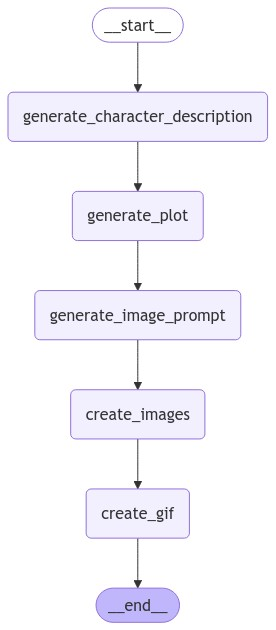

In [87]:

display(
    IPImage(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

## Run Workflow Function


In [88]:
# Run Workflow Function
# Define a function to run the workflow and display results.

async def run_workflow(query: str):
    """Run the LangGraph workflow and display results."""
    initial_state = {
        "messages": [],
        "query": query,
        "plot": "",
        "character_description": "",
        "image_prompts": [],
        "image_urls": [],
        "gif_data": None
    }

    try:
        result = await app.ainvoke(initial_state)

        print("Character/Scene Description:")
        print(result["character_description"])

        print("\nGenerated Plot:")
        print(result["plot"])

        print("\nImage Prompts:")
        for i, prompt in enumerate(result["image_prompts"], 1):
            print(f"{i}. {prompt}")

        print("\nGenerated Image URLs:")
        for i, url in enumerate(result["image_urls"], 1):
            print(f"{i}. {url}")

        if result["gif_data"]:
            print("\nGIF generated successfully. Use the next cell to display or save it.")
        else:
            print("\nFailed to generate GIF.")

        return result
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None

## Execute Workflow


In [89]:
query = "A cat wearing a top hat and monocle, sitting at a desk and writing a letter with a quill pen."
result = await run_workflow(query)


Failed to generate image for prompt: 1. **Sir Whiskerton, the sophisticated cat with his black fur, emerald eyes, and monocle, sits at an antique desk in an elegant study, writing a letter with a quill pen.**
Error: Error code: 400 - {'error': {'code': 'billing_hard_limit_reached', 'message': 'Billing hard limit has been reached', 'param': None, 'type': 'invalid_request_error'}}
Failed to generate image for prompt: 5. **Sir Whiskerton stands triumphant, hailed as a hero for his wit and bravery, his image etched in history as a revered feline gentleman.**
Error: Error code: 400 - {'error': {'code': 'billing_hard_limit_reached', 'message': 'Billing hard limit has been reached', 'param': None, 'type': 'invalid_request_error'}}
Failed to generate image for prompt: 2. **Sir Whiskerton's eyes widen as he intently reads a mysterious letter, its contents sparking curiosity and a thirst for adventure.**
Error: Error code: 400 - {'error': {'code': 'billing_hard_limit_reached', 'message': 'Billin